# Food Insecurity and Income during COVID: 
**A Natural Experiment on Resilience in Malawi**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadstat ## for reading stata
import statsmodels.api as sm ## stats models for linear regression

In [2]:
%matplotlib inline

In [3]:
from linearmodels.panel import PooledOLS

# Data

**World Bank Living Standards Measurement Surveys (LSMS) and LSMS High Frequency Phone Surveys COVID-19**

The World Bank has collected:
LSMS data on Malawi for years 2010-2011, 2013, 2016-2017, 2019-2020.  These panel data sets consist of a Household, Agricultural, Fisheries, and Community Questionnaire.  It is measured at the household and then individual level.  
The questionnaries have evolved over time meaning the majority of questions cannot be compared between the initial surveys in 2010 and current.  The total households surveyed for 2016/2017 and 2019/2020 include 12,480.

LSMS High Frequency COVID-19 phone surveys conducted in 9 rounds where questionnaires also evolved over time and therefore only the first three surveys are used for June, July, and August.  Contacted households via phone 2,337 with 1,729 or 74% of households sucessfully sampled out of the 12,480 households surveyed in the 2019 LSMS.

From these surveys in 2016, 2019, June 2020, July 2020, and August 2020 I selected the characteristics used in the model.

Household Characteristics (Qualitative): District, Urban or Rural Household, Household Size, Highest Education level in a household, Household Member Worked on a Household Farm.

Quantitative Household Data: Households where a member was forced to Skip A Meal due to an economic shock in the past 12 months (LSMS Survey) / as a result of a shock since March 2020(LSMS COVID-19 Survey/since last survey), as the result of a shock did your income decline in the past 12 months (LSMS survey)/ as a result of a shock since March 2020(LSMS COVID-19 Survey/since last survey), date

The data came from The World Bank as a Stata dataset (.dta).  All values outside of those measured were dropped.  Household data was averaged and collapsed on the district level to account for sample sizes and allowing us to account for local fixed effects.

In [4]:
Malawi = pd.read_csv('Malawi.csv')

In [5]:
Malawi.isnull().any() ## Are any values null?

District                False
date                    False
Region                  False
urb_rural               False
hhsize                  False
ReduceMealsPerDay        True
Education               False
SkipAMeal               False
RanOutOfFood            False
HungryDidntEat          False
DidntEatWholeDay        False
IncomeDecline           False
WorkHHFarm              False
WorkActivityLastWeek     True
NotEnoughFood            True
WorkedLastWeek           True
WorkedB4COVID            True
dtype: bool

All variables with null values were from questions not asked across all cohorts.

In [6]:
Malawi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   District              157 non-null    object 
 1   date                  157 non-null    int64  
 2   Region                157 non-null    float64
 3   urb_rural             157 non-null    float64
 4   hhsize                157 non-null    float64
 5   ReduceMealsPerDay     64 non-null     float64
 6   Education             157 non-null    float64
 7   SkipAMeal             157 non-null    float64
 8   RanOutOfFood          157 non-null    float64
 9   HungryDidntEat        157 non-null    float64
 10  DidntEatWholeDay      157 non-null    float64
 11  IncomeDecline         157 non-null    float64
 12  WorkHHFarm            157 non-null    float64
 13  WorkActivityLastWeek  64 non-null     float64
 14  NotEnoughFood         32 non-null     float64
 15  WorkedLastWeek        1

In [7]:
Malawi.shape # Rows/Columns

(157, 17)

157 Rows of panel data collapsed at the district level and 17 columns of variables

In [8]:
Malawi.columns

Index(['District', 'date', 'Region', 'urb_rural', 'hhsize',
       'ReduceMealsPerDay', 'Education', 'SkipAMeal', 'RanOutOfFood',
       'HungryDidntEat', 'DidntEatWholeDay', 'IncomeDecline', 'WorkHHFarm',
       'WorkActivityLastWeek', 'NotEnoughFood', 'WorkedLastWeek',
       'WorkedB4COVID'],
      dtype='object')

In [9]:
Malawi.head() # Data

,District,date,Region,urb_rural,hhsize,ReduceMealsPerDay,Education,SkipAMeal,RanOutOfFood,HungryDidntEat,DidntEatWholeDay,IncomeDecline,WorkHHFarm,WorkActivityLastWeek,NotEnoughFood,WorkedLastWeek,WorkedB4COVID
0,Chitipa,2017,1.00000,1.916667,4.088542,1.622396,1.605263,1.690104,1.684896,1.630208,1.315104,0.973958,1.085938,3.016575,1.348958,1.057292,NaN
1,Chitipa,2019,1.00000,1.916667,4.497396,0.684896,2.206897,1.507812,1.549479,1.528646,1.372396,0.518229,1.171875,2.784314,NaN,1.070312,NaN
2,Chitipa,62020,1.00000,1.961538,5.307692,NaN,3.423077,1.615385,1.692308,1.692308,1.807692,0.653846,1.217391,NaN,NaN,1.269231,2.0
3,Chitipa,72020,34.42857,1.960000,5.400000,NaN,3.520000,1.800000,1.920000,1.760000,2.000000,0.160000,1.208333,NaN,NaN,1.000000,NaN
4,Chitipa,82020,34.00000,1.923077,5.269231,NaN,3.423077,1.653846,1.730769,1.576923,2.000000,0.038462,1.217391,NaN,NaN,NaN,NaN


In [10]:
Malawi ## data set

,District,date,Region,urb_rural,hhsize,ReduceMealsPerDay,Education,SkipAMeal,RanOutOfFood,HungryDidntEat,DidntEatWholeDay,IncomeDecline,WorkHHFarm,WorkActivityLastWeek,NotEnoughFood,WorkedLastWeek,WorkedB4COVID
0,Chitipa,2017,1.00000,1.916667,4.088542,1.622396,1.605263,1.690104,1.684896,1.630208,1.315104,0.973958,1.085938,3.016575,1.348958,1.057292,NaN
1,Chitipa,2019,1.00000,1.916667,4.497396,0.684896,2.206897,1.507812,1.549479,1.528646,1.372396,0.518229,1.171875,2.784314,NaN,1.070312,NaN
2,Chitipa,62020,1.00000,1.961538,5.307692,NaN,3.423077,1.615385,1.692308,1.692308,1.807692,0.653846,1.217391,NaN,NaN,1.269231,2.000000
3,Chitipa,72020,34.42857,1.960000,5.400000,NaN,3.520000,1.800000,1.920000,1.760000,2.000000,0.160000,1.208333,NaN,NaN,1.000000,NaN
4,Chitipa,82020,34.00000,1.923077,5.269231,NaN,3.423077,1.653846,1.730769,1.576923,2.000000,0.038462,1.217391,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,Blantyre City,2017,3.00000,1.000000,3.973958,0.572917,3.160105,1.385417,1.408854,1.377604,1.283854,0.570312,1.895833,1.725373,1.713542,1.127604,NaN
153,Blantyre City,2019,3.00000,1.000000,4.022663,0.715909,3.175793,1.610796,1.517046,1.585227,1.250000,0.359773,1.872521,2.033537,NaN,1.070822,NaN
154,Blantyre City,62020,3.00000,1.065934,4.637363,NaN,3.659341,1.505494,1.560440,1.626374,1.868132,0.626374,1.528090,NaN,NaN,1.340659,1.580645
155,Blantyre City,72020,103.10000,1.068182,4.727273,NaN,3.613636,1.522727,1.590909,1.568182,1.829546,0.284091,1.532609,NaN,NaN,1.400000,1.000000


# Descriptive Statistics

In [11]:
Malawi.describe()

,date,Region,urb_rural,hhsize,ReduceMealsPerDay,Education,SkipAMeal,RanOutOfFood,HungryDidntEat,DidntEatWholeDay,IncomeDecline,WorkHHFarm,WorkActivityLastWeek,NotEnoughFood,WorkedLastWeek,WorkedB4COVID
count,157.000000,157.000000,157.000000,157.000000,64.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,64.000000,32.000000,149.000000,71.000000
mean,43484.152866,32.932030,1.790837,4.848895,1.485913,2.560310,1.532924,1.613419,1.569014,1.669968,0.634541,1.210121,2.984840,1.292452,1.237017,1.560897
std,35079.915410,41.708521,0.316146,0.664231,0.533339,0.903958,0.229384,0.158020,0.170964,0.192586,0.194696,0.191721,0.420885,0.154597,0.188426,0.336414
min,2017.000000,1.000000,1.000000,3.814621,0.437500,1.313187,1.000000,1.222222,1.241379,1.205729,0.038462,1.000000,1.725373,1.057292,1.000000,1.000000
25%,2019.000000,2.000000,1.833333,4.375979,1.196389,1.741047,1.345455,1.498264,1.433962,1.539773,0.484849,1.076923,2.894415,1.184245,1.095679,1.392308
50%,62020.000000,3.000000,1.918033,4.727273,1.466785,2.474576,1.492754,1.592814,1.538462,1.681159,0.629630,1.142046,3.061216,1.262373,1.216146,1.580645
75%,72020.000000,69.941177,1.958333,5.075472,1.749763,3.160105,1.784211,1.750000,1.730978,1.807692,0.761780,1.260870,3.269830,1.376375,1.333333,1.788889
max,82020.000000,111.658540,2.000000,7.404255,2.960938,5.459459,1.945026,1.939791,1.927083,2.000000,0.984375,1.895833,3.706714,1.713542,2.000000,2.000000


Dates: 2017, 2019, Jun 2020, July 2020, and August 2020

Regions: 3 (North, Central, South)

Districts: 28

**Binary Household Variables collapsed as the District level:**

urb_rural: Urban or Rural (2 = Rural)

hhsize: Household Size

Income Decline: Household reported an Income Decline in the past year/from previous survey (COVID-19 LSMS)

WorkedHHFarm: Worked a household farm

SkipAMeal: Household members were forced to skip a meal due to not enough food

C:\Users\emper\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='hhsize', ylabel='Density'>

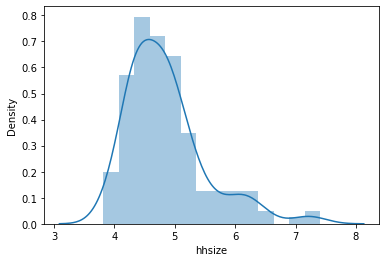

In [12]:
sns.distplot(Malawi['hhsize'])

<AxesSubplot:xlabel='Education', ylabel='Count'>

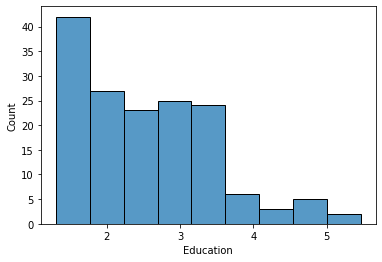

In [13]:
sns.histplot(Malawi['Education'])

0 = none, 1 = Primary, 2 = Some Secondary, 3 = Secondary, 4 = A level, 5 = College or higher

<AxesSubplot:xlabel='SkipAMeal', ylabel='Count'>

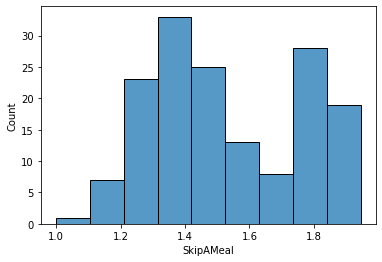

In [14]:
sns.histplot(Malawi['SkipAMeal'])

1 = No households in the district had to Skip A Meal.  2 = All households in the district had to Skip A Meal due to lack of food

<AxesSubplot:xlabel='IncomeDecline', ylabel='Count'>

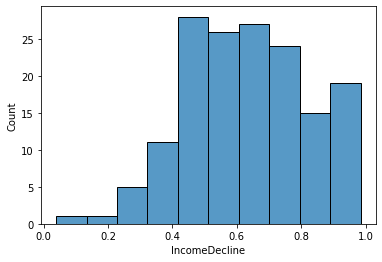

In [15]:
sns.histplot(Malawi['IncomeDecline'])

0 = No households in a district reported an income decline.  1= All households in the district reported an Income Decline

**Create AfterCOVID Variable**

AfterCOVID = 1 if after the introduction of COVID (2020) or 0 if before

In [16]:
Malawi['AfterCOVID'] = (Malawi['date'] <=2019)

In [17]:
Malawi.isnull().any()

District                False
date                    False
Region                  False
urb_rural               False
hhsize                  False
ReduceMealsPerDay        True
Education               False
SkipAMeal               False
RanOutOfFood            False
HungryDidntEat          False
DidntEatWholeDay        False
IncomeDecline           False
WorkHHFarm              False
WorkActivityLastWeek     True
NotEnoughFood            True
WorkedLastWeek           True
WorkedB4COVID            True
AfterCOVID              False
dtype: bool

In [18]:
## Change categorical variable for AfterCOVID = binary variable
Malawi=pd.get_dummies(Malawi, columns=['AfterCOVID'],drop_first=True)
Malawi.head()

,District,date,Region,urb_rural,hhsize,ReduceMealsPerDay,Education,SkipAMeal,RanOutOfFood,HungryDidntEat,DidntEatWholeDay,IncomeDecline,WorkHHFarm,WorkActivityLastWeek,NotEnoughFood,WorkedLastWeek,WorkedB4COVID,AfterCOVID_True
0,Chitipa,2017,1.00000,1.916667,4.088542,1.622396,1.605263,1.690104,1.684896,1.630208,1.315104,0.973958,1.085938,3.016575,1.348958,1.057292,NaN,1
1,Chitipa,2019,1.00000,1.916667,4.497396,0.684896,2.206897,1.507812,1.549479,1.528646,1.372396,0.518229,1.171875,2.784314,NaN,1.070312,NaN,1
2,Chitipa,62020,1.00000,1.961538,5.307692,NaN,3.423077,1.615385,1.692308,1.692308,1.807692,0.653846,1.217391,NaN,NaN,1.269231,2.0,0
3,Chitipa,72020,34.42857,1.960000,5.400000,NaN,3.520000,1.800000,1.920000,1.760000,2.000000,0.160000,1.208333,NaN,NaN,1.000000,NaN,0
4,Chitipa,82020,34.00000,1.923077,5.269231,NaN,3.423077,1.653846,1.730769,1.576923,2.000000,0.038462,1.217391,NaN,NaN,NaN,NaN,0


In [19]:
Malawi.corr()

,date,Region,urb_rural,hhsize,ReduceMealsPerDay,Education,SkipAMeal,RanOutOfFood,HungryDidntEat,DidntEatWholeDay,IncomeDecline,WorkHHFarm,WorkActivityLastWeek,NotEnoughFood,WorkedLastWeek,WorkedB4COVID,AfterCOVID_True
date,1.000000,0.708921,-0.105756,0.579161,-0.131608,0.582090,-0.805715,-0.574277,-0.675713,0.758731,-0.586321,-0.070125,0.007052,NaN,0.409420,0.002605,-0.983719
Region,0.708921,1.000000,-0.038111,0.354640,0.435760,0.362351,-0.516043,-0.363243,-0.369504,0.570885,-0.603678,-0.056825,0.119979,-0.356972,0.310058,-0.133857,-0.612203
urb_rural,-0.105756,-0.038111,1.000000,0.101153,0.476197,-0.357881,0.161943,0.299631,0.213875,0.079372,0.183579,-0.792950,0.862128,-0.757459,-0.088016,0.035005,0.104833
hhsize,0.579161,0.354640,0.101153,1.000000,-0.127021,0.394347,-0.489693,-0.489845,-0.501434,0.280920,-0.250809,-0.115254,0.120858,0.014162,0.062497,-0.176326,-0.578146
ReduceMealsPerDay,-0.131608,0.435760,0.476197,-0.127021,1.000000,-0.589580,0.755053,0.768359,0.774450,0.680967,0.405701,-0.589360,0.508007,-0.751986,0.106213,NaN,NaN
Education,0.582090,0.362351,-0.357881,0.394347,-0.589580,1.000000,-0.587522,-0.555472,-0.564127,0.301373,-0.461288,0.277350,-0.869173,0.835590,0.213827,-0.166301,-0.596112
SkipAMeal,-0.805715,-0.516043,0.161943,-0.489693,0.755053,-0.587522,1.000000,0.792038,0.869489,-0.425274,0.434554,-0.032803,0.830519,-0.934693,-0.334331,0.014407,0.828852
RanOutOfFood,-0.574277,-0.363243,0.299631,-0.489845,0.768359,-0.555472,0.792038,1.000000,0.822452,-0.091568,0.335088,-0.265716,0.784396,-0.905010,-0.245951,0.057331,0.592098
HungryDidntEat,-0.675713,-0.369504,0.213875,-0.501434,0.774450,-0.564127,0.869489,0.822452,1.000000,-0.244863,0.380589,-0.152278,0.761333,-0.905474,-0.227824,0.114443,0.710251
DidntEatWholeDay,0.758731,0.570885,0.079372,0.280920,0.680967,0.301373,-0.425274,-0.091568,-0.244863,1.000000,-0.435295,-0.257331,0.734006,-0.773752,0.397487,0.130637,-0.739100


<AxesSubplot:>

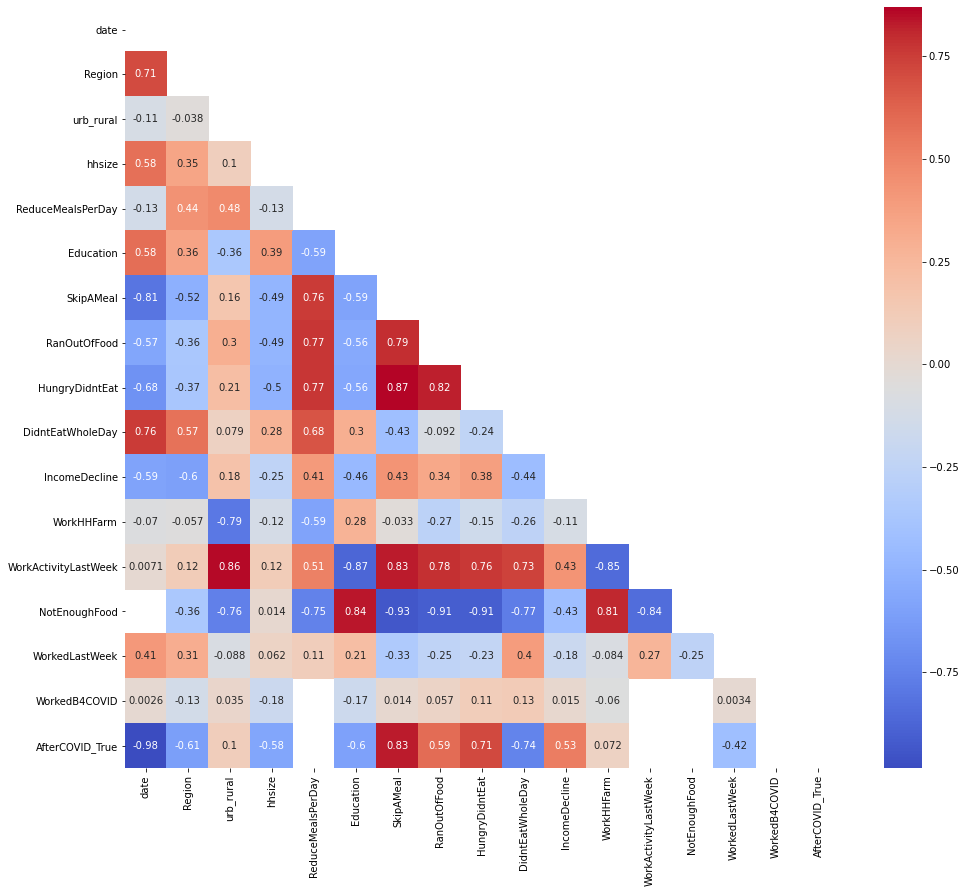

In [20]:
matrix = np.triu(Malawi.corr())
plt.figure(figsize=(16,14))
sns.heatmap(Malawi.corr(), annot=True, mask=matrix, cmap='coolwarm')

**Member of household forced to Skip A Meal**

For our regression we use SkipAMeal for food insecurity as we can see it is highly correlated with other measures of food insecurity Ran out of food for the household (0.77), Hungary but did not eat (0.87), not enough food (0.93), and did not eat for an entire day (0.43).

**Household Income Decline**

We can also see that income decline as would be expected does have a moderate correlation with food insecurity.  We also see a moderate correlation between it and Education level, household size, if a household member worked last week, and before/after COVID

In [21]:
heatmap1_data = pd.pivot_table(Malawi, values='SkipAMeal',
                               index=['District'],
                               columns='date')

<AxesSubplot:xlabel='date', ylabel='District'>

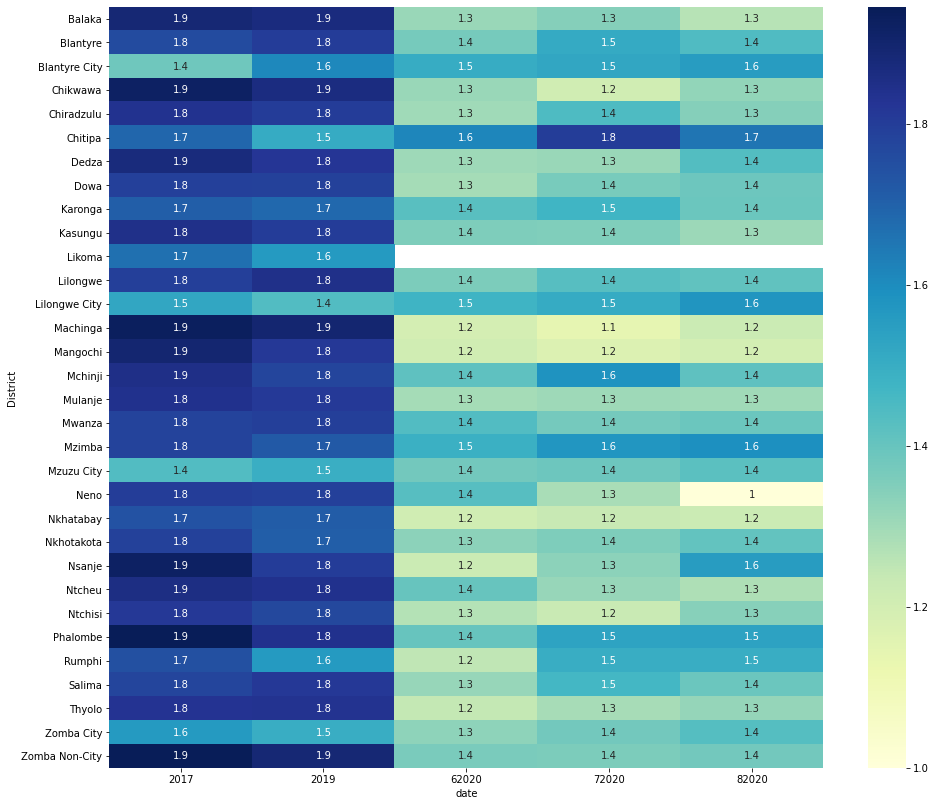

In [22]:
plt.figure(figsize=(16,14))
sns.heatmap(heatmap1_data, annot=True, cmap="YlGnBu")

The SkipAMeal heatmap shows by District the number of households being forced to Skip A Meal where we can see in 2017 a much larger number of households were forced to skip a meal.  In the 2016-2017 survey Malawi had suffered a severe drought.  In 2018 Malawi suffered devistation from Cyclone Idai landing in March which in the southern hemisphere is harvest season destroying as much as 20% of crops.  

SkipAMeal = 1 (0% households skipped a meal), 2 = 100% households Skipped A Meal.

In [23]:
heatmap2_data = pd.pivot_table(Malawi, values='IncomeDecline',
                               index=['District'],
                               columns='date')

<AxesSubplot:xlabel='date', ylabel='District'>

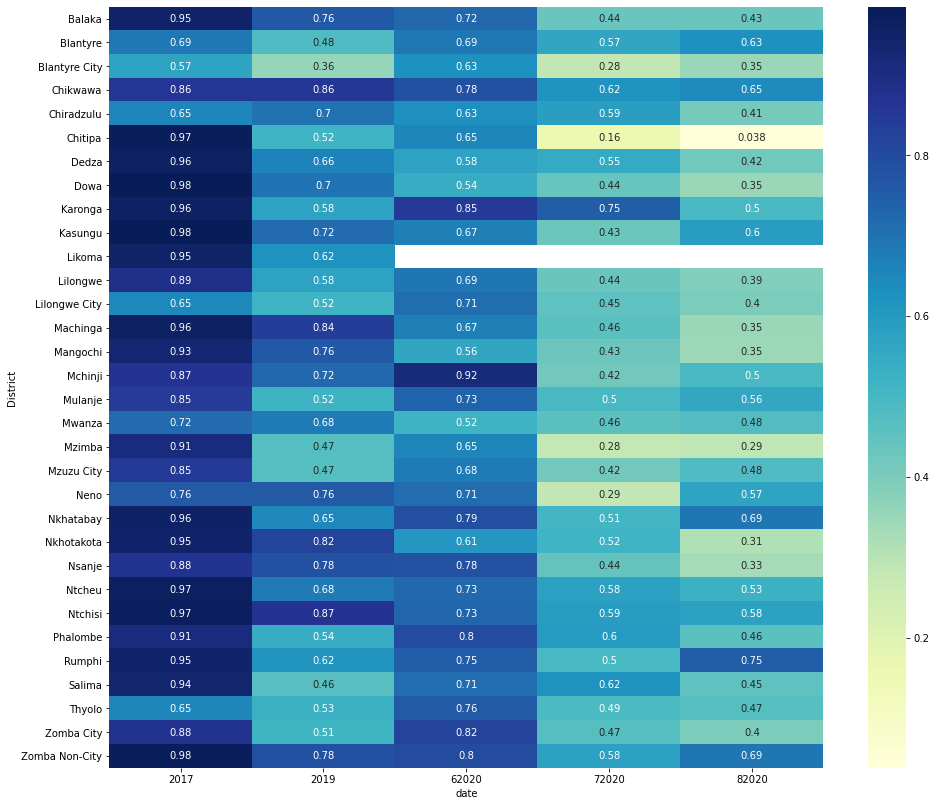

In [24]:
plt.figure(figsize=(16,14))
sns.heatmap(heatmap2_data, annot=True, cmap="YlGnBu")

The IncomeDecline heatmap shows a different outlook on households that faced a decline in income due to a financial shock. We see the number of households reporting an income decline is lower in 2019 compared to 2016-2017 but similar in June 2020 with declines into July and August.  Import to note harvest season is April-June.

IncomeDecline = 0 (0% households reported a decline in income), 1 = 100% reported a decline in income.

**Set Index: set the multi-index using the entity and time**

In [25]:
year = pd.Categorical(Malawi.date)

In [26]:
Malawi = Malawi.set_index(['District', 'date'])

## Stata Setup

In [27]:
import stata_setup
stata_setup.config("C:/Program Files/Stata17", "se")


  ___  ____  ____  ____  ____ ©
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       SE—Standard Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Single-user  perpetual
Serial number: 401706332304
  Licensed to: Michael Murray
               

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. Maximum number of variables is set to 5,000; see help set_maxvar.


In [28]:
from pystata import stata

**Import Data**

In [29]:
%stata use "C:\Users\emper\OneDrive\Desktop\Grad School\ECON676 Econ Develop\Final Report\Data\Combined Data\Combined Collapsed by District\Combined LSMS and High Freq by District V6.dta"

**Create AfterCOVID and Education level variables**

In [30]:
%%stata
sort District date
xtset District date

gen AfterCOVID = 1
replace AfterCOVID = 0 if date==2017
replace AfterCOVID = 0 if date==2019
label var AfterCOVID "=1 After start of pandemic"

replace Region=1 if Region>3 & Region<60
replace Region=2 if Region>60 & Region<100
replace Region=3 if Region>100
label define Region1 1 "North" 2 "Central" 3 "South"
label values Region Region1

* Create Education level variable
gen Educationlvl = 0
replace Educationlvl = 1 if Education>.5
replace Educationlvl = 2 if Education>1.5
replace Educationlvl = 3 if Education>2.5
replace Educationlvl = 4 if Education>3.5
replace Educationlvl = 5 if Education>4.5
label var Educationlvl "Avg lvl of Education"
label define Edulvl 1 "None" 2 "Primary" 3 "Some Secondary" 4 "Secondary" 5 "A-level"
label values Educationlvl Edulvl


. sort District date

. xtset District date

Panel variable: District (unbalanced)
 Time variable: date, 2017 to 82020, but with gaps
         Delta: 1 unit

. 
. gen AfterCOVID = 1

. replace AfterCOVID = 0 if date==2017
(32 real changes made)

. replace AfterCOVID = 0 if date==2019
(32 real changes made)

. label var AfterCOVID "=1 After start of pandemic"

. 
. replace Region=1 if Region>3 & Region<60
(12 real changes made)

. replace Region=2 if Region>60 & Region<100
(20 real changes made)

. replace Region=3 if Region>100
(30 real changes made)

. label define Region1 1 "North" 2 "Central" 3 "South"

. label values Region Region1

. 
. * Create Education level variable
. gen Educationlvl = 0

. replace Educationlvl = 1 if Education>.5
(157 real changes made)

. replace Educationlvl = 2 if Education>1.5
(145 real changes made)

. replace Educationlvl = 3 if Education>2.5
(75 real changes made)

. replace Educationlvl = 4 if Education>3.5
(24 real changes made)

. replace Educatio

# Regression Analysis

Using the LSMS surveys from 2017, 2019, and the first three high-frequency LSMS COVID-19 surveys I was able to match several questions asked across all five surveys to create a model to study the impact of COVID-19 on Malawi.  The LSMS surveys in 2017 and 2019 each sampled 12,480 households.  The high-frequency phone surveys used the same sample population as the 2019 LSMS survey.  Out of the 2,337 households in this sample, 74% were successfully contacted for the initial round or 1,729 households for the June sample.  The follow-ups for July and August were 1,646 and 1,598, respectively.  In order to compare these results to the 2017 survey, the results were collapsed into the 32 Districts in the country.

## Regression Equation:

SkipAMealdt = α + ß1dtAfterCOVID + ß2dtRural + ß3dtHHSize + ß4dtWorkedHHFarm + ß5dtDate + ß6dtEducationlvl + ε

IncomeDeclinedt = α + ß1dtAfterCOVID + ß2dtRural + ß3dtHHSize + ß4dtWorkedHHFarm + ß5dtDate + ß6dtEducationlvl + ε

# Regression Analysis - Food Insecurity (SkipAMeal)

In [31]:
from linearmodels import PanelOLS ## Import to run regression - Entity effects = Fixed effects

In [32]:
linearmodel1 = PanelOLS(Malawi[['SkipAMeal']],Malawi[['AfterCOVID_True']], entity_effects=True).fit()

In [33]:
print(linearmodel1)

                          PanelOLS Estimation Summary                           
Dep. Variable:              SkipAMeal   R-squared:                        0.7390
Estimator:                   PanelOLS   R-squared (Between):              0.2012
No. Observations:                 157   R-squared (Within):               0.7390
Date:                Thu, Jul 22 2021   R-squared (Overall):              0.2075
Time:                        12:04:12   Log-likelihood                    119.65
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      351.18
Entities:                          32   P-value                           0.0000
Avg Obs:                       4.9062   Distribution:                   F(1,124)
Min Obs:                       2.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             351.18
                            

In [34]:
%%stata
xtreg SkipAMeal AfterCOVID, fe vce(cluster District)
eststo SkipReg1


. xtreg SkipAMeal AfterCOVID, fe vce(cluster District)

Fixed-effects (within) regression               Number of obs     =        157
Group variable: District                        Number of groups  =         32

R-squared:                                      Obs per group:
     Within  = 0.7390                                         min =          2
     Between = 0.0596                                         avg =        4.9
     Overall = 0.6870                                         max =          5

                                                F(1,31)           =     110.03
corr(u_i, Xb) = -0.0387                         Prob > F          =     0.0000

                              (Std. err. adjusted for 32 clusters in District)
------------------------------------------------------------------------------
             |               Robust
   SkipAMeal | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+-------------------------------------

In [35]:
linearmodel2 = PanelOLS(Malawi[['SkipAMeal']],Malawi[['AfterCOVID_True', 'urb_rural']], entity_effects=True).fit()

In [36]:
print(linearmodel2)

                          PanelOLS Estimation Summary                           
Dep. Variable:              SkipAMeal   R-squared:                        0.7393
Estimator:                   PanelOLS   R-squared (Between):              0.0987
No. Observations:                 157   R-squared (Within):               0.7393
Date:                Thu, Jul 22 2021   R-squared (Overall):              0.1067
Time:                        12:04:13   Log-likelihood                    119.73
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      174.42
Entities:                          32   P-value                           0.0000
Avg Obs:                       4.9062   Distribution:                   F(2,123)
Min Obs:                       2.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             174.42
                            

In [37]:
%%stata
xtreg SkipAMeal AfterCOVID urb_rural, fe vce(cluster District)
eststo SkipReg2


. xtreg SkipAMeal AfterCOVID urb_rural, fe vce(cluster District)

Fixed-effects (within) regression               Number of obs     =        157
Group variable: District                        Number of groups  =         32

R-squared:                                      Obs per group:
     Within  = 0.7393                                         min =          2
     Between = 0.0142                                         avg =        4.9
     Overall = 0.6730                                         max =          5

                                                F(2,31)           =     122.06
corr(u_i, Xb) = -0.0725                         Prob > F          =     0.0000

                              (Std. err. adjusted for 32 clusters in District)
------------------------------------------------------------------------------
             |               Robust
   SkipAMeal | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+---------------------------

In [38]:
linearmodel3 = PanelOLS(Malawi[['SkipAMeal']],Malawi[['AfterCOVID_True', 'urb_rural', 'hhsize']], entity_effects=True).fit()

In [39]:
print(linearmodel3)

                          PanelOLS Estimation Summary                           
Dep. Variable:              SkipAMeal   R-squared:                        0.7395
Estimator:                   PanelOLS   R-squared (Between):              0.0335
No. Observations:                 157   R-squared (Within):               0.7395
Date:                Thu, Jul 22 2021   R-squared (Overall):              0.0428
Time:                        12:04:13   Log-likelihood                    119.80
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      115.47
Entities:                          32   P-value                           0.0000
Avg Obs:                       4.9062   Distribution:                   F(3,122)
Min Obs:                       2.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             115.47
                            

In [40]:
%%stata
xtreg SkipAMeal AfterCOVID urb_rural hhsize, fe vce(cluster District)
eststo SkipReg3


. xtreg SkipAMeal AfterCOVID urb_rural hhsize, fe vce(cluster District)

Fixed-effects (within) regression               Number of obs     =        157
Group variable: District                        Number of groups  =         32

R-squared:                                      Obs per group:
     Within  = 0.7395                                         min =          2
     Between = 0.0144                                         avg =        4.9
     Overall = 0.6737                                         max =          5

                                                F(3,31)           =      89.02
corr(u_i, Xb) = -0.0710                         Prob > F          =     0.0000

                              (Std. err. adjusted for 32 clusters in District)
------------------------------------------------------------------------------
             |               Robust
   SkipAMeal | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+--------------------

In [41]:
linearmodel4 = PanelOLS(Malawi[['SkipAMeal']],Malawi[['AfterCOVID_True', 'urb_rural', 'hhsize', 'WorkHHFarm']], entity_effects=True).fit()

In [42]:
print(linearmodel4)

                          PanelOLS Estimation Summary                           
Dep. Variable:              SkipAMeal   R-squared:                        0.7539
Estimator:                   PanelOLS   R-squared (Between):             -1.1680
No. Observations:                 157   R-squared (Within):               0.7539
Date:                Thu, Jul 22 2021   R-squared (Overall):             -1.1329
Time:                        12:04:13   Log-likelihood                    124.23
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      92.644
Entities:                          32   P-value                           0.0000
Avg Obs:                       4.9062   Distribution:                   F(4,121)
Min Obs:                       2.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             92.644
                            

In [43]:
%%stata
xtreg SkipAMeal AfterCOVID urb_rural hhsize WorkHHFarm, fe vce(cluster District)
eststo SkipReg4


. xtreg SkipAMeal AfterCOVID urb_rural hhsize WorkHHFarm, fe vce(cluster Distri
> ct)

Fixed-effects (within) regression               Number of obs     =        157
Group variable: District                        Number of groups  =         32

R-squared:                                      Obs per group:
     Within  = 0.7539                                         min =          2
     Between = 0.0873                                         avg =        4.9
     Overall = 0.6585                                         max =          5

                                                F(4,31)           =      68.02
corr(u_i, Xb) = -0.1190                         Prob > F          =     0.0000

                              (Std. err. adjusted for 32 clusters in District)
------------------------------------------------------------------------------
             |               Robust
   SkipAMeal | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+------

In [44]:
Malawi['date'] = year

In [45]:
linearmodel5 = PanelOLS(Malawi[['SkipAMeal']],Malawi[['AfterCOVID_True', 'urb_rural', 'hhsize', 'WorkHHFarm', 'date']], entity_effects=True).fit()

In [46]:
print(linearmodel5)

                          PanelOLS Estimation Summary                           
Dep. Variable:              SkipAMeal   R-squared:                        0.7599
Estimator:                   PanelOLS   R-squared (Between):             -0.5519
No. Observations:                 157   R-squared (Within):               0.7599
Date:                Thu, Jul 22 2021   R-squared (Overall):              0.6706
Time:                        12:04:13   Log-likelihood                    126.20
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      53.366
Entities:                          32   P-value                           0.0000
Avg Obs:                       4.9062   Distribution:                   F(7,118)
Min Obs:                       2.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             70.024
                            

# Stata

** Use 2017 instead of 2019 as the baseline.  2017 there was an immense drought in Malawi that reduced food security

** Stata allows us to easily cluster at the district level further reducing the significance where in python we overestimate the coefficent and significance (T-value) while clustering allows us to reduce heteroskedasticity in the results

In [47]:
%%stata
xtreg SkipAMeal AfterCOVID urb_rural hhsize WorkHHFarm b2019.date, fe vce(cluster District)
eststo SkipReg5


. xtreg SkipAMeal AfterCOVID urb_rural hhsize WorkHHFarm b2019.date, fe vce(clu
> ster District)
note: 82020.date omitted because of collinearity.

Fixed-effects (within) regression               Number of obs     =        157
Group variable: District                        Number of groups  =         32

R-squared:                                      Obs per group:
     Within  = 0.7599                                         min =          2
     Between = 0.0610                                         avg =        4.9
     Overall = 0.6717                                         max =          5

                                                F(7,31)           =     127.60
corr(u_i, Xb) = -0.1032                         Prob > F          =     0.0000

                              (Std. err. adjusted for 32 clusters in District)
------------------------------------------------------------------------------
             |               Robust
   SkipAMeal | Coefficient  std. err. 

In [48]:
linearmodel6 = PanelOLS(Malawi[['SkipAMeal']],Malawi[['AfterCOVID_True', 'urb_rural', 'hhsize', 'WorkHHFarm', 'Education','date']], entity_effects=True).fit()

In [49]:
print(linearmodel6)

                          PanelOLS Estimation Summary                           
Dep. Variable:              SkipAMeal   R-squared:                        0.7684
Estimator:                   PanelOLS   R-squared (Between):             -0.4352
No. Observations:                 157   R-squared (Within):               0.7684
Date:                Thu, Jul 22 2021   R-squared (Overall):              0.6864
Time:                        12:04:14   Log-likelihood                    129.02
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      48.527
Entities:                          32   P-value                           0.0000
Avg Obs:                       4.9062   Distribution:                   F(8,117)
Min Obs:                       2.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             63.508
                            

In [50]:
%%stata
xtreg SkipAMeal AfterCOVID urb_rural hhsize WorkHHFarm b2019.date i.Educationlvl, fe vce(cluster District)
eststo SkipReg6


. xtreg SkipAMeal AfterCOVID urb_rural hhsize WorkHHFarm b2019.date i.Education
> lvl, fe vce(cluster District)
note: 82020.date omitted because of collinearity.

Fixed-effects (within) regression               Number of obs     =        157
Group variable: District                        Number of groups  =         32

R-squared:                                      Obs per group:
     Within  = 0.7898                                         min =          2
     Between = 0.0002                                         avg =        4.9
     Overall = 0.7081                                         max =          5

                                                F(11,31)          =      60.45
corr(u_i, Xb) = -0.1078                         Prob > F          =     0.0000

                              (Std. err. adjusted for 32 clusters in District)
------------------------------------------------------------------------------
             |               Robust
   SkipAMeal | Coeffici

In [51]:
%%stata
testparm i.date
testparm i.Educationlvl


. testparm i.date

 ( 1)  2017.date = 0
 ( 2)  62020.date = 0
 ( 3)  72020.date = 0

       F(  3,    31) =    1.29
            Prob > F =    0.2936

. testparm i.Educationlvl

 ( 1)  2.Educationlvl = 0
 ( 2)  3.Educationlvl = 0
 ( 3)  4.Educationlvl = 0
 ( 4)  5.Educationlvl = 0

       F(  4,    31) =    2.55
            Prob > F =    0.0585

. 


In [52]:
from linearmodels.panel import compare ## Model comparisons

In [53]:
print(compare({'AfterCOVID':linearmodel1,'urb_rural':linearmodel2,'hhsize':linearmodel3,'WorkHHFarm':linearmodel4,'Education':linearmodel5,'date':linearmodel6}))

                                                 Model Comparison                                                
                            AfterCOVID      urb_rural         hhsize     WorkHHFarm      Education           date
-----------------------------------------------------------------------------------------------------------------
Dep. Variable                SkipAMeal      SkipAMeal      SkipAMeal      SkipAMeal      SkipAMeal      SkipAMeal
Estimator                     PanelOLS       PanelOLS       PanelOLS       PanelOLS       PanelOLS       PanelOLS
No. Observations                   157            157            157            157            157            157
Cov. Est.                   Unadjusted     Unadjusted     Unadjusted     Unadjusted     Unadjusted     Unadjusted
R-squared                       0.7390         0.7393         0.7395         0.7539         0.7599         0.7684
R-Squared (Within)              0.7390         0.7393         0.7395         0.7539     

C:\Users\emper\anaconda3\lib\site-packages\linearmodels\panel\results.py:1010: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  vals = concat(


In [54]:
%%stata
esttab SkipReg3 SkipReg4 SkipReg5 SkipReg6


----------------------------------------------------------------------------
                      (1)             (2)             (3)             (4)   
                SkipAMeal       SkipAMeal       SkipAMeal       SkipAMeal   
----------------------------------------------------------------------------
AfterCOVID         -0.384***       -0.406***       -0.375***       -0.341***
                  (-5.53)         (-6.36)         (-5.05)         (-4.81)   

urb_rural         -0.0445          -0.232          -0.208          -0.158   
                  (-0.26)         (-1.30)         (-1.12)         (-0.79)   

hhsize            -0.0113        -0.00733         -0.0109        -0.00123   
                  (-0.23)         (-0.16)         (-0.22)         (-0.02)   

WorkHHFarm                         -0.364          -0.353          -0.221   
                                  (-1.41)         (-1.32)         (-0.89)   

2017.date                                          0.0292         0.002

Running the full model, the number of households being forced to skip a meal maintains a statistically significant correlation with the introduction of COVID at the 1% level.  The model predicts after the introduction of COVID a 34% lower chance of a family being forced to skip a meal.  I believe there are two primary problems with drawing any causal inference from this regression.  First is there was a severe drought in 2017 with lasting impacts such that the effects of the shock were still resonating in 2019 preventing the establishment of a baseline.  Second, I have an issue with seasonality.  The surveys were conducted just after the harvest season in Malawi.  If a district was more rural, had a higher hhsize, or worked on a household farm did not predict whether a household was forced to skip a meal.  This directly contrasts with Fisher and Lewin’s 2013 paper findings of a 25% increase in food insecurity for the addition of just one child.  Education also shows statistically significant reductions.

## Regression Analysis - Income Decline

In [55]:
incomelinearmodel1 = PanelOLS(Malawi[['IncomeDecline']],Malawi[['AfterCOVID_True']], entity_effects=True).fit()

In [56]:
print(incomelinearmodel1)

                          PanelOLS Estimation Summary                           
Dep. Variable:          IncomeDecline   R-squared:                        0.3186
Estimator:                   PanelOLS   R-squared (Between):              0.2506
No. Observations:                 157   R-squared (Within):               0.3186
Date:                Thu, Jul 22 2021   R-squared (Overall):              0.2499
Time:                        12:04:14   Log-likelihood                    78.366
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      57.974
Entities:                          32   P-value                           0.0000
Avg Obs:                       4.9062   Distribution:                   F(1,124)
Min Obs:                       2.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             57.974
                            

In [57]:
%%stata
xtreg IncomeDecline AfterCOVID, vce(cluster District)
eststo IReg1


. xtreg IncomeDecline AfterCOVID, vce(cluster District)

Random-effects GLS regression                   Number of obs     =        157
Group variable: District                        Number of groups  =         32

R-squared:                                      Obs per group:
     Within  = 0.3186                                         min =          2
     Between = 0.1172                                         avg =        4.9
     Overall = 0.2756                                         max =          5

                                                Wald chi2(1)      =      82.23
corr(u_i, X) = 0 (assumed)                      Prob > chi2       =     0.0000

                              (Std. err. adjusted for 32 clusters in District)
------------------------------------------------------------------------------
             |               Robust
IncomeDecl~e | Coefficient  std. err.      z    P>|z|     [95% conf. interval]
-------------+------------------------------------

In [58]:
incomelinearmodel2 = PanelOLS(Malawi[['IncomeDecline']],Malawi[['AfterCOVID_True', 'urb_rural']], entity_effects=True).fit()

In [59]:
print(incomelinearmodel2)

                          PanelOLS Estimation Summary                           
Dep. Variable:          IncomeDecline   R-squared:                        0.3304
Estimator:                   PanelOLS   R-squared (Between):             -1.4722
No. Observations:                 157   R-squared (Within):               0.3304
Date:                Thu, Jul 22 2021   R-squared (Overall):             -1.3610
Time:                        12:04:14   Log-likelihood                    79.743
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      30.350
Entities:                          32   P-value                           0.0000
Avg Obs:                       4.9062   Distribution:                   F(2,123)
Min Obs:                       2.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             30.350
                            

In [60]:
%%stata
xtreg IncomeDecline AfterCOVID urb_rural, fe vce(cluster District)
eststo IReg2


. xtreg IncomeDecline AfterCOVID urb_rural, fe vce(cluster District)

Fixed-effects (within) regression               Number of obs     =        157
Group variable: District                        Number of groups  =         32

R-squared:                                      Obs per group:
     Within  = 0.3304                                         min =          2
     Between = 0.0869                                         avg =        4.9
     Overall = 0.1098                                         max =          5

                                                F(2,31)           =      44.47
corr(u_i, Xb) = -0.5028                         Prob > F          =     0.0000

                              (Std. err. adjusted for 32 clusters in District)
------------------------------------------------------------------------------
             |               Robust
IncomeDecl~e | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+-----------------------

In [61]:
incomelinearmodel3 = PanelOLS(Malawi[['IncomeDecline']],Malawi[['AfterCOVID_True', 'urb_rural', 'hhsize']], entity_effects=True).fit()

In [62]:
print(incomelinearmodel3)

                          PanelOLS Estimation Summary                           
Dep. Variable:          IncomeDecline   R-squared:                        0.3406
Estimator:                   PanelOLS   R-squared (Between):             -3.0637
No. Observations:                 157   R-squared (Within):               0.3406
Date:                Thu, Jul 22 2021   R-squared (Overall):             -2.8462
Time:                        12:04:14   Log-likelihood                    80.940
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      21.002
Entities:                          32   P-value                           0.0000
Avg Obs:                       4.9062   Distribution:                   F(3,122)
Min Obs:                       2.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             21.002
                            

In [63]:
%%stata
xtreg IncomeDecline AfterCOVID urb_rural hhsize, fe vce(cluster District)
eststo IReg3


. xtreg IncomeDecline AfterCOVID urb_rural hhsize, fe vce(cluster District)

Fixed-effects (within) regression               Number of obs     =        157
Group variable: District                        Number of groups  =         32

R-squared:                                      Obs per group:
     Within  = 0.3406                                         min =          2
     Between = 0.1560                                         avg =        4.9
     Overall = 0.0958                                         max =          5

                                                F(3,31)           =      27.52
corr(u_i, Xb) = -0.5347                         Prob > F          =     0.0000

                              (Std. err. adjusted for 32 clusters in District)
------------------------------------------------------------------------------
             |               Robust
IncomeDecl~e | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------

In [64]:
incomelinearmodel4 = PanelOLS(Malawi[['IncomeDecline']],Malawi[['AfterCOVID_True', 'urb_rural', 'hhsize', 'WorkHHFarm']], entity_effects=True).fit()

In [65]:
print(incomelinearmodel4)

                          PanelOLS Estimation Summary                           
Dep. Variable:          IncomeDecline   R-squared:                        0.3466
Estimator:                   PanelOLS   R-squared (Between):             -5.8908
No. Observations:                 157   R-squared (Within):               0.3466
Date:                Thu, Jul 22 2021   R-squared (Overall):             -5.4804
Time:                        12:04:15   Log-likelihood                    81.662
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      16.046
Entities:                          32   P-value                           0.0000
Avg Obs:                       4.9062   Distribution:                   F(4,121)
Min Obs:                       2.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             16.046
                            

In [66]:
%%stata
xtreg IncomeDecline AfterCOVID urb_rural hhsize WorkHHFarm, fe vce(cluster District)
eststo IReg4


. xtreg IncomeDecline AfterCOVID urb_rural hhsize WorkHHFarm, fe vce(cluster Di
> strict)

Fixed-effects (within) regression               Number of obs     =        157
Group variable: District                        Number of groups  =         32

R-squared:                                      Obs per group:
     Within  = 0.3466                                         min =          2
     Between = 0.1826                                         avg =        4.9
     Overall = 0.0965                                         max =          5

                                                F(4,31)           =      21.29
corr(u_i, Xb) = -0.5412                         Prob > F          =     0.0000

                              (Std. err. adjusted for 32 clusters in District)
------------------------------------------------------------------------------
             |               Robust
IncomeDecl~e | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+--

In [67]:
incomelinearmodel5 = PanelOLS(Malawi[['IncomeDecline']],Malawi[['AfterCOVID_True', 'urb_rural', 'hhsize', 'WorkHHFarm', 'date']], entity_effects=True).fit()

In [68]:
print(incomelinearmodel5)

                          PanelOLS Estimation Summary                           
Dep. Variable:          IncomeDecline   R-squared:                        0.7386
Estimator:                   PanelOLS   R-squared (Between):             -2.3152
No. Observations:                 157   R-squared (Within):               0.7386
Date:                Thu, Jul 22 2021   R-squared (Overall):              0.2189
Time:                        12:04:15   Log-likelihood                    153.57
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      47.622
Entities:                          32   P-value                           0.0000
Avg Obs:                       4.9062   Distribution:                   F(7,118)
Min Obs:                       2.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             50.373
                            

In [69]:
%%stata
xtreg IncomeDecline AfterCOVID urb_rural hhsize WorkHHFarm b2019.date, fe vce(cluster District)
eststo IReg5


. xtreg IncomeDecline AfterCOVID urb_rural hhsize WorkHHFarm b2019.date, fe vce
> (cluster District)
note: 82020.date omitted because of collinearity.

Fixed-effects (within) regression               Number of obs     =        157
Group variable: District                        Number of groups  =         32

R-squared:                                      Obs per group:
     Within  = 0.7386                                         min =          2
     Between = 0.1063                                         avg =        4.9
     Overall = 0.3428                                         max =          5

                                                F(7,31)           =      43.96
corr(u_i, Xb) = -0.4699                         Prob > F          =     0.0000

                              (Std. err. adjusted for 32 clusters in District)
------------------------------------------------------------------------------
             |               Robust
IncomeDecl~e | Coefficient  std. e

In [70]:
incomelinearmodel6 = PanelOLS(Malawi[['IncomeDecline']],Malawi[['AfterCOVID_True', 'urb_rural', 'hhsize', 'WorkHHFarm', 'Education','date']], entity_effects=True).fit()

In [71]:
print(incomelinearmodel6)

                          PanelOLS Estimation Summary                           
Dep. Variable:          IncomeDecline   R-squared:                        0.7399
Estimator:                   PanelOLS   R-squared (Between):             -2.0739
No. Observations:                 157   R-squared (Within):               0.7399
Date:                Thu, Jul 22 2021   R-squared (Overall):              0.2611
Time:                        12:04:15   Log-likelihood                    153.98
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      41.610
Entities:                          32   P-value                           0.0000
Avg Obs:                       4.9062   Distribution:                   F(8,117)
Min Obs:                       2.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             44.009
                            

In [72]:
%%stata
xtreg IncomeDecline AfterCOVID urb_rural hhsize WorkHHFarm b2019.date i.Educationlvl, fe vce(cluster District)
eststo IReg6


. xtreg IncomeDecline AfterCOVID urb_rural hhsize WorkHHFarm b2019.date i.Educa
> tionlvl, fe vce(cluster District)
note: 82020.date omitted because of collinearity.

Fixed-effects (within) regression               Number of obs     =        157
Group variable: District                        Number of groups  =         32

R-squared:                                      Obs per group:
     Within  = 0.7566                                         min =          2
     Between = 0.0954                                         avg =        4.9
     Overall = 0.3773                                         max =          5

                                                F(11,31)          =      49.89
corr(u_i, Xb) = -0.4401                         Prob > F          =     0.0000

                              (Std. err. adjusted for 32 clusters in District)
------------------------------------------------------------------------------
             |               Robust
IncomeDecl~e | Coef

In [73]:
%%stata
testparm i.date
testparm i.Educationlvl


. testparm i.date

 ( 1)  2017.date = 0
 ( 2)  62020.date = 0
 ( 3)  72020.date = 0

       F(  3,    31) =   49.36
            Prob > F =    0.0000

. testparm i.Educationlvl

 ( 1)  2.Educationlvl = 0
 ( 2)  3.Educationlvl = 0
 ( 3)  4.Educationlvl = 0
 ( 4)  5.Educationlvl = 0

       F(  4,    31) =    2.64
            Prob > F =    0.0528

. 


In [74]:
print(compare({'urb_rural':incomelinearmodel2,'hhsize':incomelinearmodel3,'WorkHHFarm':incomelinearmodel4,'Education':incomelinearmodel5,'date':incomelinearmodel6}))

                                                 Model Comparison                                                
                                urb_rural            hhsize        WorkHHFarm         Education              date
-----------------------------------------------------------------------------------------------------------------
Dep. Variable               IncomeDecline     IncomeDecline     IncomeDecline     IncomeDecline     IncomeDecline
Estimator                        PanelOLS          PanelOLS          PanelOLS          PanelOLS          PanelOLS
No. Observations                      157               157               157               157               157
Cov. Est.                      Unadjusted        Unadjusted        Unadjusted        Unadjusted        Unadjusted
R-squared                          0.3304            0.3406            0.3466            0.7386            0.7399
R-Squared (Within)                 0.3304            0.3406            0.3466           

In [75]:
%%stata
esttab IReg3 IReg4 IReg5 IReg6


----------------------------------------------------------------------------
                      (1)             (2)             (3)             (4)   
             IncomeDecl~e    IncomeDecl~e    IncomeDecl~e    IncomeDecl~e   
----------------------------------------------------------------------------
AfterCOVID         -0.172***       -0.183***       -0.217***       -0.190***
                  (-3.95)         (-4.12)         (-5.28)         (-5.03)   

urb_rural          -0.235          -0.333*         -0.397**        -0.373** 
                  (-1.88)         (-2.31)         (-3.32)         (-3.19)   

hhsize            -0.0622         -0.0601          0.0120         0.00865   
                  (-1.43)         (-1.36)          (0.44)          (0.33)   

WorkHHFarm                         -0.190          -0.144         -0.0778   
                                  (-1.36)         (-1.03)         (-0.60)   

2017.date                                           0.228***        0.2

Regarding income, we also see a reduction in households who have had suffered a decline in income of 37% at the 1% level.  Interestingly rural households also are more insulated to declines in income with a reduction of 27% at the 10% level.  Households in 2017 were 20% more likely to have a decline in income compared to 2019.  Immediately post-pandemic in June we see an increase of 25% of households experiencing a decline in income but this becomes statistically insignificant by July.  This points to an initial shock of households experiencing a one-time decline in income. However, this does not mean that incomes recovered just that the number of households experiencing a decline did not increase between the March-June time period and the July-August period.  Education also plays a role with a statistically significant reduction in those who suffered a reduction in income.  The more educated a district the lower the fraction of those suffering an income loss.

# Conclusion

This project proposes a way to examine the impact of the COVID-19 shock on income utilizing cell phone technology to make faster policy decisions.  Previously policymakers had to wait for economic data to be aggregated.  Utilizing cell phones, the response can be done much faster.  Using difference-in-differences methodology and including such factors as whether a casual relationship may be determinable on the impact of COVID-19 on income among the world’s poor.

The regression on the introduction of COVID-19 and the number of households reporting a decline in income yielded surprising results.  We expect to see an increase after the start of the pandemic but instead, find a decrease.  This shows why making a casual assumption can be problematic.  When including dates post COVID we do see a sharp increase in the number of households reporting a decline in income for June of 25% but it appears this is a one-time shock with statistically insignificant results by July and August.  Of further note is that rural households were 37% less likely to report a decline in income when we include the date.  I speculate this is because they are more resilient to the impacts of the pandemic.  Whether due to the nature of the type of work rural communities engage in, seasonality, or because rural communities are less affected overall it appears to be an important factor. 

The real unanswered question of what is the impact of COVID still remains.  Have the impacts not manifested themselves yet?  Could the positive upwards trends in food security and income masked the effects?  Or are the Malawian people insulated by repeated shocks and better prepared?  It warrants future study and I believe my thoughts on focusing on better data such as rainfall along with stronger methods described here could ascertain the answer.
